# Make Effective Visualization

[Cédric Campguilhem](https://github.com/ccampguilhem), January 2018

<a id="Top">

## Table of Contents

- [1. Introduction](#Introduction)
- [2. Project organization](#Project)
- [3. Questions](#Questions)
- [4. Data wrangling](#Wrangling)
    - [4.1 Download of datasets](#Download)
    - [4.2 Flights dataset](#Flights)
    - [4.3 Airports dataset](#Airports)
    - [4.4 Carriers dataset](#Carriers)
    - [4.5 Aircrafts dataset](#Aircrafts)
    - [4.6 Merging datasets](#Merging)
- [5. Exploratory data analysis](#Exploratory)
    - [5.1 Traffic](#Traffic)
    - [5.2 Routes and aircrafts](#RoutesAircrafts)
    - [5.3 Delays](#Delays)
- [6. Data preparation for visualization](#Preparation)
- [7. Appendix](#Appendix)

<a id="Introduction">

## 1. Introduction [*Top*](#Top)

This project is related to Data Visualization course for Udacity Data Analyst Nanodegree program. The purpose of this project is to make an effective visualization using [D3.js](https://d3js.org/).

I have chosen to work with the flights dataset and will be using the 2008 dataset of commercial flights in  the United States.

This project covers the following steps of data analysis process:

- Questions
- Data wrangling
- Exploratory data analysis
- Visualization of findings

In the data wrangling phase we are going to enrich the flights dataset with additional information regarding:

- Airports
- Carriers
- Aircrafts

Airports dataset will help us making a map visualization. Carriers dataset will be used to get airline names. Aircrafts dataset will be use to check if differences are observed in the dataset depending on the aircraft that is operated. The datasets are provided by http://stat-computing.org.

This notebook will cover questions, data wrangling, exploratory data analysis and data preparation for visualization. The visualization itself will be created in a separated html document.

<a id="Project">

## 2. Project Organization

The project contains:

- this notebook file,
- a [html-converted](./effective_visualization.html) version of the notebook file,
- a [dataset](./dataset) folder in which datasets required for analysis have been downloaded,
- a [template](./html_minimal.tpl) for html conversion of current notebook.

<a id="Questions">

## 3. Questions [*Top*](#Top)

We may ask the following questions regarding the dataset we have:

- Traffic releated questions:
    - Which are the airports with biggest traffic ?
    - Is there any weekday with more traffic ?
    - Is there any month with more traffic ?
- Routes and aircrafts:
    - How many different routes ?
    - What are the main routes in national flights in United States ?
    - Which aircrafts are operated in United states
    - How many cumulated flights/distance for given aircraft model ?
- Delays:
    - Are there some months or airports where flight delays due to weather conditions are more likely ?
    - Do some airlines experiment more delays than others ?
    - Do some aircrafts experiment more delays than others ?

Those questions will drive the exploratory data analysis phase. The most intersting finding will then be communicated with a dedicated data visualization.

<a id="Wrangling">

## 4. Data Wrangling [*Top*](#Top)

<a id="Download">

### 4.1 Download of Datasets [*Data Wrangling*](#Wrangling)

This notebook takes care of downloading any dataset required for the analysis. The flights dataset may take a while to be downloaded. If the files already have been downloaded, download is skipped. All datasets are stored in a *dataset* folder in the same folder than this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import requests
import shutil
import bz2
import sys


def download_file(url, dest):
    """
    Download file at given URL.
    
    - url: url of file to be downloaded
    - return: downloaded file name
    """
    filename = url.split('/')[-1]
    path = os.path.join(dest, filename)
    r = requests.get(url, stream=True)
    with open(path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    return path


def decompress(filename):
    """
    Decompress file using Bzip2
    
    - filename: name of file to be decompressed
    - return: path to decompressed path
    """
    if filename.endswith('.bz2'):
        output = filename[:-4]
        with bz2.BZ2File(filename, 'rb') as fin, open(output, 'wb') as fout:
            while 1:
                data = fin.readline()
                if not data:
                    break
                else:
                    fout.write(data)
        os.remove(filename)
        return output
    else:
        return filename


def download_dataset(url, dest, force=False):
    """
    Download dataset at specified url and store it at specified destination.
    
    - url: url of dataset to be downloaded
    - dest: destination folder of dataset on filesystem
    - force: force download even if file already exists
    """
    fullpath = url.split('/')[-1]
    if fullpath.endswith('.bz2'):
        fullpath = fullpath[:-4]
    fullpath = os.path.join(dest, fullpath)
    if os.path.exists(fullpath) and not force:
        return
    else:
        print "Now downloading {} dataset. This may take a while... ".format(url),
        sys.stdout.flush()
        filename = download_file(url, dest)
        print "done"
        if filename.endswith(".bz2"):
            print "Now extracting {}. This may take a while... ".format(filename),
            sys.stdout.flush()
            decompress(filename)
            print "done"        

In [3]:
download_dataset("http://stat-computing.org/dataexpo/2009/2008.csv.bz2", "./dataset")
download_dataset("http://stat-computing.org/dataexpo/2009/airports.csv", "./dataset")
download_dataset("http://stat-computing.org/dataexpo/2009/carriers.csv", "./dataset")
download_dataset("http://stat-computing.org/dataexpo/2009/plane-data.csv", "./dataset")

The following datasets are available:

Path                                             | Description
:----------------------------------------------- | :-----------
[dataset/2008.csv](dataset/2008.csv)             | Flights dataset
[dataset/airports.csv](dataset/airports.csv)     | Airports dataset
[dataset/carriers.csv](dataset/carriers.csv)     | Carriers dataset
[dataset/plane-data.csv](dataset/plane-data.csv) | Aircrafts dataset

<a id="Flights">

### 4.2 Flights Dataset  [*Data Wrangling*](#Wrangling)

We are now going to read and clean the dataset. The following operations are taken in the cleaning phase:

- Month and DayOfWeek will be replaced with categorcial values
- DepTime and CRSDepTime will be converted into hours and names will be replaced with ActualDep and ScheduledDep respectively
- ArrTime and CRSArrTime will be converted into hours and names will be replaced with ActualArr and ScheduledArr respectively
- ActualElapsedTime and CRSElapsedTime will be replaced with ActualElapsed and ScheduledElapsed respectively
- Cancelled and Diverted will be converted to booleans values
- Cancellation code will be replaced with categorical values
- UniqueCarrier will be converted to categorical data
- TailNum, Dest and Origin are converted to categorical data
- The Year, FlightNum, TaxiIn, TaxiOut and AirTime are removed
- Flights for which TailNum is missing are removed
- If ArrDelay is lower or equal to zero, change missing CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay to zero.
- Add UnknownDelay column for each row where either delay is still NaN. The parameter is equal to ArrDelay in that case.
- Adjust types precision to reduce memory usage

In [4]:
import pandas as pd
import numpy as np


def read_flights_dataset(filename):
    """
    Clean flights dataset
    
    - filename: dataset filename
    - return: cleaned dataset
    """
    #Read dataset
    df = pd.read_csv(filename)
    
    #Drop columns we do not need
    df.drop(["Year", "FlightNum", "TaxiIn", "TaxiOut", "AirTime"], axis=1, inplace=True)
    
    #Remove flights for which aircraft (tail number) is missing
    df = df[df.TailNum.notnull()]
    
    #Replace Month and DayOfWeek with categorical values
    df.DayOfWeek = df.DayOfWeek.map({1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday",
                                    6: "Saturday", 7: "Sunday"}, na_action="ignore").astype('category')
    df.Month = df.Month.map({1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
                            7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 
                            12: "December"}, na_action="ignore").astype('category')
    #Rename colums
    df.rename(columns={"DayofMonth": "DayOfMonth", 
                       "DepTime": "ActualDep", 
                       "CRSDepTime": "ScheduledDep",
                       "ArrTime": "ActualArr",
                       "CRSArrTime": "ScheduledArr",
                       "ActualElapsedTime": "ActualElapsed",
                       "CRSElapsedTime": "ScheduledElapsed"
                      }, inplace=True)
    
    #Convert to boolean values
    df.Cancelled = df.Cancelled.astype(bool)
    df.Diverted = df.Diverted.astype(bool)
    
    #Convert hours hhmm into decimal hours
    def convert_hhmm_to_float(series):
        if series.name in ["ActualDep", "ScheduledDep", "ActualArr", "ScheduledArr"]:
            return np.floor(series / 100) + (series % 100) / 60.
        else:
            return series
    df = df.apply(convert_hhmm_to_float)
    
    #Cancellation code to categorical value
    df.CancellationCode = df.CancellationCode.map({"A": "Carrier", "B": "Weather", "C": "NationalAirSystem", 
                                                   "D": "Security"}, na_action="ignore").astype("category")
    df.UniqueCarrier = df.UniqueCarrier.astype("category")
    df.TailNum = df.TailNum.astype("category")    
    
    #Dest and Origin to categorical value
    df.Dest = df.Dest.astype("category")
    df.Origin = df.Origin.astype("category")
    
    #Update missing CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay to zero if ArrDelay is <= 0
    for param in ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]:
        df[param] = df[param].where(df.ArrDelay > 0., 0.)
    
    #Fix remaining NaN in delays and add OtherDelay
    df["UnknownDelay"] = 0.
    condition = (df["CarrierDelay"].isnull() | df["WeatherDelay"].isnull() | df["NASDelay"].isnull() | 
                df["SecurityDelay"].isnull() | df["LateAircraftDelay"].isnull())
    df.UnknownDelay = df.UnknownDelay.where(~condition, df.ArrDelay)
    df.fillna(value={"CarrierDelay": 0., "WeatherDelay": 0., "NASDelay": 0., "SecurityDelay": 0., 
                      "LateAircraftDelay": 0.}, inplace=True)
    
    #Reduce precision on some values
    df.DayOfMonth = df.DayOfMonth.astype("uint8")
    df.Distance = df.Distance.astype("uint16")
    df.CarrierDelay = df.CarrierDelay.astype("float32")
    df.WeatherDelay = df.WeatherDelay.astype("float32")
    df.NASDelay = df.NASDelay.astype("float32")
    df.SecurityDelay = df.SecurityDelay.astype("float32")
    df.LateAircraftDelay = df.LateAircraftDelay.astype("float32")
    df.UnknownDelay = df.UnknownDelay.astype("float32")
    df.ActualDep = df.ActualDep.astype("float32")
    df.ScheduledDep = df.ScheduledDep.astype("float32")
    df.ActualArr = df.ActualArr.astype("float32")
    df.ScheduledArr = df.ScheduledArr.astype("float32")
    df.ActualElapsed = df.ActualElapsed.astype("float32")
    df.ScheduledElapsed = df.ScheduledElapsed.astype("float32")
    df.ArrDelay = df.ArrDelay.astype("float32")
    df.DepDelay = df.DepDelay.astype("float32")
    
    #End
    return df

In [5]:
flights_df = read_flights_dataset("./dataset/2008.csv")
flights_df.shape

(6926363, 25)

The dataset contains almost 7 millions of flights and 25 parameters:

Parameter        | Unit             | Description
:----------------|:-----------------|:-----------
Month            | categorical      | Month in full letter (January, February...)
DayOfMonth       |                  | Day of month 1-31
DayOfWeek        | categorical      | Day of week in full letter (Monday, Tuesday...)
ActualDep        | hours            | Actual departure time
ScheduledDep     | hours            | Scheduled departure time
ActualArr        | hours            | Actual arrival time
ScheduledArr     | hours            | Scheduled arrival time
UniqueCarrier    | category         | Carrier code
TailNum          |                  | Aircraft tail number
ActualElapsed    | minutes          | Actual elapsed time between departure and arrival (taxi + air time)
ScheduledElapsed | minutes          | Scheduled elapsed time between departure and arrival (taxi + air time)
ArrDelay         | minutes          | Delay at arrival
DepDelay         | minutes          | Delay at departure
Origin           |                  | IATA code of origin airport
Dest             |                  | IATA code of destination airport
Cancelled        | boolean          | Cancellation flag for flight
CancellationCode | categorical      | Cancellation code (Weather, NationalAirSystem, Carrier, Security)
Diverted         | boolean          | Diverted flag for flight
CarrierDelay     | minutes          | Delay due to carrier
WeatherDelay     | minutes          | Delay due to weather conditions
NASDelay         | minutes          | Delay due to National Air System
SecurityDelay    | minutes          | Delay due to security
LateAircraftDelay| minutes          | Delay due to late arrival of aircraft
UnknownDelay     | minutes          | Delay due to unknown cause (fix of input dataset)


<a id="Airports">

### 4.3 Airports Dataset  [*Data Wrangling*](#Wrangling)

Let's read and clean the airports dataset:

- We only keep airports in United States, the country parameter is then removed.
- There are 8 airports with IATA codes: CLD, HHH, MIB, MQT, RCA, RDR, SCE, SKA with no information. I have used Wikipedia to fill missing information.
- Convert IATA code and state to categorical values
- Reduce accuracy on numerical type to save memory

In [6]:
def read_airports_dataset(filename):
    """
    Read and clean airports dataset.
    
    - filename: path of dataset
    - return: airports dataset
    """
    #Read dataset
    df = pd.read_csv(filename)
    
    #Only keep USA airports
    df = df[df.country == "USA"]
    df.drop(["country"], axis=1, inplace=True)
    
    #Fill missing values
    df[df.iata == "CLD"] = ("CLD", "MC Clellan-Palomar Airport", "Carlsbad", "CA", 33.127231, -117.278727)
    df[df.iata == "HHH"] = ("HHH", "Hilton Head", "Hilton Head Island", "SC", 32.224384, -80.697629)
    df[df.iata == "MIB"] = ("MIB", "Minot AFB", "Minot", "ND", 48.415769, -101.358039)
    df[df.iata == "MQT"] = ("MQT", "Marquette County Airport", "Marquette", "MI", 46.353639, -87.395361)
    df[df.iata == "RCA"] = ("RCA", "Ellsworth AFB", "Box Elder", "SD", 44.145094, -103.103567)
    df[df.iata == "RDR"] = ("RDR", "Grand Forks AFB", "Emerado", "ND", 47.961167, -97.401167)
    df[df.iata == "SCE"] = ("SCE", "University Park", "State College", "PA", 40.851206, -77.846302)
    df[df.iata == "SKA"] = ("SKA", "Fairchild AFB", "Spokane", "WA", 47.615058, -117.655803)
    
    #Convert to categorical data
    df.iata = df.iata.astype("category")
    df.state = df.state.astype("category")
    
    #Reduce memory usage
    df.lat = df.lat.astype("float32")
    df.long = df.long.astype("float32")
    
    #End
    return df

In [7]:
airports_df = read_airports_dataset("./dataset/airports.csv")
airports_df.shape

(3372, 6)

The dataset contains 3372 airports and 6 parameters for each airport:

Parameter        | Unit             | Description
:----------------|:-----------------|:-----------
iata             |                  | [IATA airport code](https://en.wikipedia.org/wiki/List_of_airports)
airport          |                  | Airport name
city             |                  | Nearby city
state            |                  | State ([postal abbreviations](https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States))
lat              | °                | latitude (positive value for North)
long             | °                | longitude (positive value for East)


<a id="Carriers">

### 4.4 Carriers Dataset  [*Data Wrangling*](#Wrangling)

Now it's time to read the carriers dataset and perform the following cleaning operations:
- North American Airlines IATA code is missing and set to NA
- Fix name for US Airways (remove mention to merge with America West Airlines)
- Fix name for America West Airlines (remove mention to merge with US Airways)
- Convert IATA code to categorical value

In [8]:
def read_carriers_dataset(filename):
    """
    Read and clean carriers dataset.
    
    - filename: path of dataset
    - return: carriers dataset
    """
    #Read csv
    df = pd.read_csv(filename)
    
    #Fix missing IATA code
    df.loc[df.Description == "North American Airlines", "Code"] = "NA"
    
    #Fix US Airways and Amercian Southwest names
    df.loc[df.Description.str.contains("US Airways Inc."), "Description"] = "US Airways Inc."
    df.loc[df.Description.str.contains("America West Airlines Inc."), "Description"] = "America West Airlines Inc."
    
    #Convert to categorical value
    df.Code = df.Code.astype("category")
    
    #End
    return df

In [9]:
carriers_df = read_carriers_dataset("./dataset/carriers.csv")
carriers_df.shape

(1491, 2)

The dataset contains almost 1500 carriers and 2 parameters:

Parameter        | Unit             | Description
:----------------|:-----------------|:-----------
Code             |                  | IATA code
Description      |                  | Airline fullname

<a id="Aircrafts">

### 4.5 Aircrafts Dataset  [*Data Wrangling*](#Wrangling)

The last dataset that we need to read and clean is the aircrafts dataset. The following operations have been taken to clean the dataset:

- Only keep Fixed Wing Multi-Engine aircrafts.
- Drop the type, issue_date, status, aircraft_type and engine_type parameters.
- Remove each row for which aircraft model is unknown.
- Remove each row for which entry into service is unknown.
- Regroup manufacturers:
    - BOEING: BOEING, BOEING OF CANADA LTD
    - AIRBUS: AIRBUS INDUSTRIE, AIRBUS
    - ATR: AEROSPATIALE, AEROSPATIALE/ALENIA (except aircraft model AS 355F1 which is AIRBUS/EUROCOPTER)
    - MCDONNELL DOUGLAS: MCDONNELL DOUGLAS, MCDONNELL DOUGLAS AIRCRAFT CO, MCDONNELL DOUGLAS CORPORATION, DOUGLASS
- Rename few models to give consistent name for each manufacturer.
- Convert manufacturer and model to categorical value.
- Convert year to numerical type while fixing missing values using http://airfleets.net. Remove all aircrafts for which year is missing and has not been fixed.

In [10]:
from tailnum_year import tailnum_year


def read_aircrafts_dataset(filename):
    """
    Read and clean aircrafts dataset.
    
    - filename: path of dataset
    - return: aircrafts dataset
    """
    #Read csv
    df = pd.read_csv(filename)
    
    #Only keep Fixed Wing Multi-Engine aircrafts
    df = df[df.aircraft_type == "Fixed Wing Multi-Engine"]
    
    #Drop columns
    df.drop(["aircraft_type", "engine_type", "type", "issue_date", "status"], axis=1, inplace=True)
    
    #Drop any row with missing model
    df.dropna(axis=0, subset=["model"], inplace=True)
    
    #Fix AS 355F1
    df.loc[df.model == "AS 355F1", "manufacturer"] = "AIRBUS"
    
    #Add max range feature (in nautic miles)
#     df["MaxRange"] = None
#     df.loc[df["model"] == "CL-600-2B19", "MaxRange"] = 1700.
#     df.loc[df["model"] == "737-7H4", "MaxRange"] = 3010.
#     df.loc[df["model"] == "A320-232", "MaxRange"] = 3300.
#     df.loc[df["model"] == "EMB-145LR", "MaxRange"] = 1550.
#     df.loc[df["model"] == "CL-600-2C10", "MaxRange"] = 1378.
#     df.loc[df["model"] == "737-3H4", "MaxRange"] = 2060.
#     df.loc[df["model"] == "MD-82", "MaxRange"] = 2050.
#     df.loc[df["model"] == "MD-88", "MaxRange"] = 2550.
#     df.loc[df["model"] == "757-232", "MaxRange"] = 3900.
#     df.loc[df["model"] == "EMB-145XR", "MaxRange"] = 2000.
#     df.loc[df["model"] == "737-824", "MaxRange"] = 3010.
#     df.loc[df["model"] == "717-200", "MaxRange"] = 2060.
#     df.loc[df["model"] == "757-222", "MaxRange"] = 3915.
#     df.loc[df["model"] == "767-332", "MaxRange"] = 3900.
#     df.loc[df["model"] == "737-832", "MaxRange"] = 3010.
#     df.loc[df["model"] == "CL-600-2D24", "MaxRange"] = 1378.
    
    #Regroup aircrafts manufacturers
    df.manufacturer.replace({"BOEING OF CANADA LTD": "BOEING", 
                             "AIRBUS INDUSTRIE": "AIRBUS",
                             "AEROSPATIALE": "ATR", "AEROSPATIALE/ALENIA": "ATR",
                             "MCDONNELL DOUGLAS AIRCRAFT CO": "MCDONNELL DOUGLAS", 
                             "MCDONNELL DOUGLAS CORPORATION": "MCDONNELL DOUGLAS",
                             "DOUGLAS": "MCDONNELL DOUGLAS"}, inplace=True)
    
    #Regroup aircrafts models
    df.model.replace({"ATR 72-212": "ATR-72-212", 
                     "CL600-2D24": "CL-600-2D24", 
                     "MD 83": "MD-83", 
                     "DC-9-82(MD-82)": "MD-82", 
                     "DC-9-83(MD-83)": "MD-83",
                     "S55A": "S-55A"},
                     inplace=True)
    
    #Convert to categorical values
    df.manufacturer = df.manufacturer.astype("category")
    df.model = df.model.astype("category")
    
    #Fix years and to numerical type
    for key, value in tailnum_year.iteritems():
        df.loc[df.tailnum == key, "year"] = value    
    df = df[df.year != "None"]
    df.year = df.year.astype("uint16")
    
    #Drop rows with missing years
    df = df[df.year > 0]
        
    #End
    return df

In [11]:
aircrafts_df = read_aircrafts_dataset("./dataset/plane-data.csv")
aircrafts_df.shape

(4435, 4)

The dataset contains 4435 different aircrafts with 4 parameters:

Parameter        | Unit             | Description
:----------------|:-----------------|:-----------
tailnum          |                  | Tail number
manufacturer     |                  | Aircraft manufacturer
model            |                  | Aircraft model
year             |                  | Year of entry into service

<a id="Merging">

### 4.6 Merging Dataset  [*Data Wrangling*](#Wrangling)

In this section, we will combine all previously introduced datasets into one that will be used for exploratory data analysis. We start by merging flights dataset with aircrafts dataset:

In [12]:
overall_df = flights_df.merge(aircrafts_df, how='inner', left_on="TailNum", right_on="tailnum")
overall_df.drop(["tailnum"], axis=1, inplace=True)
overall_df.rename(columns={"manufacturer": "Manufacturer", "model": "Model", "year": "EntryIntoService"}, inplace=True)
del flights_df, aircrafts_df

In [13]:
overall_df.shape

(6159269, 28)

After the merge operation, some flights have been dropped because aircraft tail number has not been found in the aircraft dataset. This still lets us with more than 6 millions of flights in the dataset.

Now we can combine the carriers dataset:

In [14]:
overall_df = overall_df.merge(carriers_df, how='left', left_on='UniqueCarrier', right_on='Code')
overall_df.drop(["Code"], axis=1, inplace=True)
overall_df.rename(columns={"UniqueCarrier": "AirlineCode", "Description": "Airline"}, inplace=True)
overall_df.AirlineCode = overall_df.AirlineCode.astype("category")
del carriers_df

In [15]:
overall_df.Airline.isnull().sum()

0

The merge is successful, all flights have been associated with an airline.

The last merge with airports will be done in two times because we need to merge with origin airport and with destination airport.

In [16]:
overall_df = overall_df.merge(airports_df, how='left', left_on='Origin', right_on='iata')
overall_df.drop(["iata"], axis=1, inplace=True)
overall_df.rename(columns={"airport": "OriginAirport", "city": "OriginCity", "state": "OriginState", 
                           "lat": "OriginLat", "long": "OriginLong"}, inplace=True)

In [17]:
overall_df.OriginLat.isnull().sum()

0

Merge is successful, origin airports have all been found in airports dataset. We can proceed with destination airports:

In [18]:
overall_df = overall_df.merge(airports_df, how='left', left_on='Dest', right_on='iata')
overall_df.drop(["iata"], axis=1, inplace=True)
overall_df.rename(columns={"airport": "DestAirport", "city": "DestCity", "state": "DestState", 
                           "lat": "DestLat", "long": "DestLong"}, inplace=True)
overall_df.Origin = overall_df.Origin.astype("category")
overall_df.Dest = overall_df.Dest.astype("category")
del airports_df

In [19]:
overall_df.DestLat.isnull().sum()

0

All merge are completed. Apart from issues when merging with aircraft dataset everything is fine. We still have to add another variable Route. This variable will hold a concatenation of origin and destination airport so that airport1 - airport2 and airport2 - airport1 are considered to be on the same route. This will help us for visualization.

In [20]:
def create_route(origin, dest):
    """
    Create route from origin and destination.
    
    origin and destination are arranged lexycographically so that A - B and B - A are actually
    the same route.
    
    - origin: series with origin airport IATA codes
    - dest: series with dest airport IATA codes
    - return: route series
    """
    output = [ ]
    for o, d in zip(origin, dest):
        if (o < d):
            output.append("{}-{}".format(o, d))
        else:
            output.append("{}-{}".format(d, o))
    return pd.Series(output)

In [21]:
overall_df["Route"] = create_route(overall_df.Origin, overall_df.Dest)
overall_df["Route"] = overall_df["Route"].astype("category")
overall_df["Route"].unique().shape

(2686,)

This leads to 2686 different routes in United States.

<a id="Exploratory">

## 5. Exploratory Data Analysis [*Top*](#Top)

The dataset is now ready for exploratory analysis. We will try in this section to answer all questions asked in section [Questions](#Questions). The questions have been split by theme and are adressed in the following sections.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

<a id="Traffic">

### 5.1 Traffic [*Exploratory data analysis*](#Exploratory)

We refer, in this section, to traffic in terms of flights number. We have no access to number of passengers.

First, we count all flights from a given airport:

In [23]:
from_df = (overall_df
          .groupby([overall_df.OriginCity, overall_df.OriginAirport])
          .agg({"Origin": [("number", "count")]})
         )
from_df.columns = from_df.columns.droplevel(level=1)
from_df.index.rename(["City", "Airport"], inplace=True)
from_df.rename(columns={"Origin": "FlightsFrom"}, inplace=True)

Then, we do the same with all flights to a given airport:

In [24]:
to_df = (overall_df
          .groupby([overall_df.DestCity, overall_df.DestAirport])
          .agg({"Dest": [("number", "count")]})
         )
to_df.columns = to_df.columns.droplevel(level=1)
to_df.index.rename(["City", "Airport"], inplace=True)
to_df.rename(columns={"Dest": "FlightsTo"}, inplace=True)

We now combine both dataframes:

In [25]:
flights_df = pd.concat([from_df, to_df], axis=1)
del from_df, to_df
flights_df = (flights_df
             .fillna(0.) #some airports may not have either flights from or flights to
             .applymap(int)) #we enforce integer type

We create an additional column to sum flights from anf flights to airport:

In [26]:
flights_df["Flights"] = flights_df["FlightsFrom"] + flights_df["FlightsTo"]
flights_df.reset_index(inplace=True)
flights_df.sort_values("Flights", ascending=False, inplace=True)

The 25 airports with most national traffic (flights from plus flights to) are listed below. The biggest airport is Atlanta airport. With a traffic of almost 800000 flights a year, it is equivalent to almost hundred of flights leaving or arriving at Atlanta every single hour ! And this is only for national flights.

Atlanta airport has a traffic twice as big as the one in Phoenix, which is the 4th biggest airport in terms of traffic.

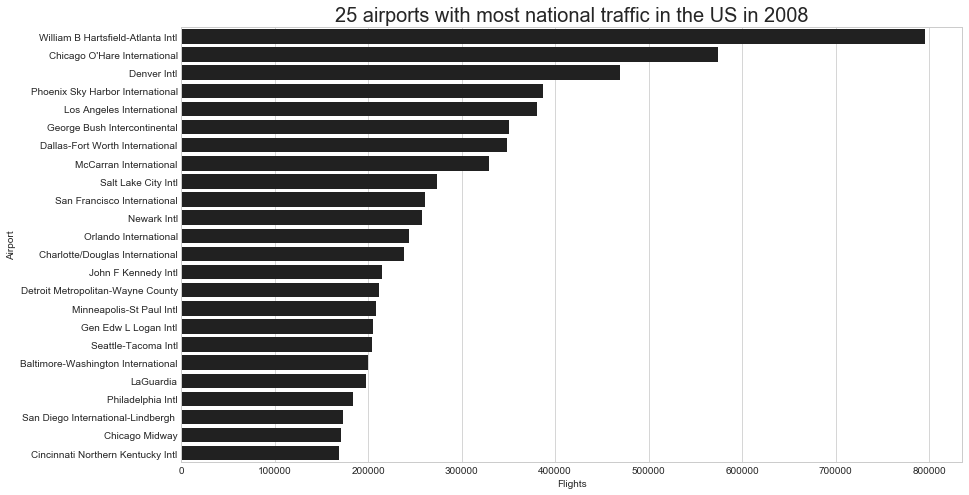

In [27]:
ax = sns.barplot(x="Flights", y="Airport", color="#212121", orient="h", data=flights_df[:24])
title = ax.set_title("25 airports with most national traffic in the US in 2008", fontsize=20)

In [28]:
del flights_df

We are now interested in seing the distribution of number of flights in year or in week.

In [29]:
months_df = (overall_df
            .groupby("Month")
            .agg({"Origin": [("number", "count")]}))
months_df.columns = months_df.columns.droplevel(level=1)
months_df.rename(columns={"Origin": "Flights"}, inplace=True)
months_df.reset_index(inplace=True)

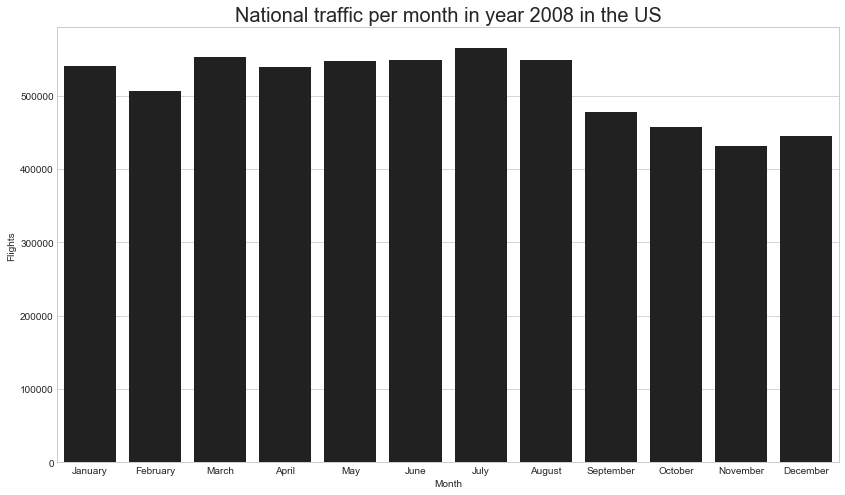

In [30]:
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", 
               "September", "October", "November", "December"]
ax = sns.barplot(x="Month", y="Flights", color="#212121", orient="v", 
                 order=month_order, data=months_df)
title = ax.set_title("National traffic per month in year 2008 in the US", fontsize=20)

The month with most traffic is July. Traffic is lower in November, December and October.

In [31]:
del months_df

In [32]:
weekday_df = (overall_df
            .groupby("DayOfWeek")
            .agg({"Origin": [("number", "count")]}))
weekday_df.columns = weekday_df.columns.droplevel(level=1)
weekday_df.rename(columns={"Origin": "Flights"}, inplace=True)
weekday_df.reset_index(inplace=True)
weekday_df["WeekEnd"] = False
weekday_df.loc[weekday_df["DayOfWeek"].isin(["Saturday", "Sunday"]), "WeekEnd"] = True

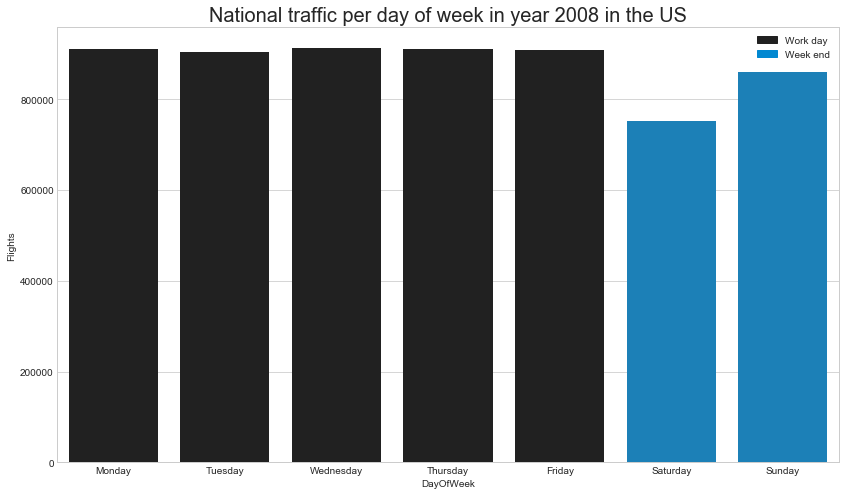

In [33]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
palette = map(lambda x: "#0288d1" if x in ["Sunday", "Saturday"] else "#212121", day_order)
ax = sns.barplot(x="DayOfWeek", y="Flights", palette=palette, orient="v", 
                 order=day_order, data=weekday_df)
title = ax.set_title("National traffic per day of week in year 2008 in the US", fontsize=20)
handles = [mpatches.Patch(color="#212121", label="Work day"),  mpatches.Patch(color="#0288d1", label="Week end")]
ax.legend(handles=handles);

The traffic is significantly lower on week end, more specifically for saturdays. For the other days of the week traffic is comparable.

In [34]:
del weekday_df

<a id="RoutesAircrafts">

### 5.2 Routes and Aircrafts [*Exploratory data analysis*](#Exploratory)

Let's start with routes. We are mostly interested in finding the routes with highest traffic and see if the major routes change during the course of the year.

In [35]:
routes_df = (overall_df
            .groupby(["Route", "OriginCity", "DestCity", "Distance","Month", "Manufacturer", "Model", 
                      "TailNum", "Airline"], as_index=False)
            .agg({"Origin": "count"})
            .rename(columns={"Origin": "Flights"}))
print routes_df.shape

(3510920, 10)


In [36]:
routes_agg = (routes_df
              .groupby("Route")
              .agg({"Distance": "first"})
              .dropna(subset=["Distance"]))

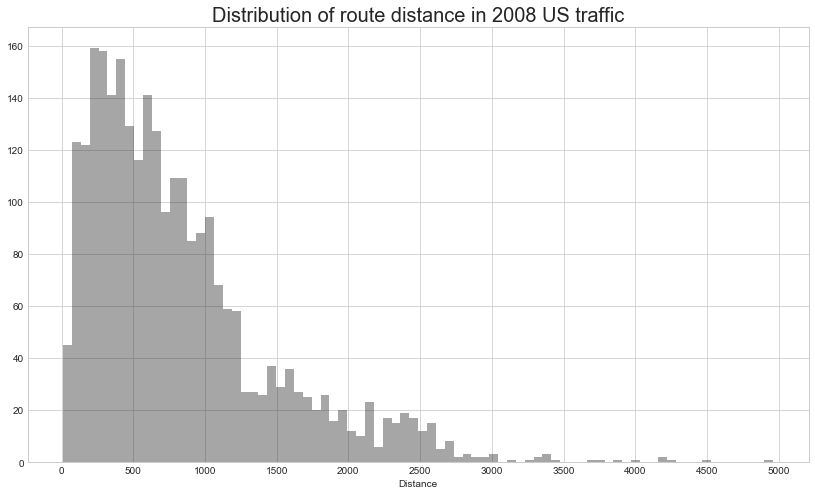

In [37]:
ax = sns.distplot(routes_agg.Distance, color='#212121', bins=80, kde=False)
title = ax.set_title("Distribution of route distance in 2008 US traffic", fontsize=20)
ticks = ax.set_xticks(np.arange(0., 5500., 500.))

The longest route is about 5000 nautic miles. But the most frequent routes are between 250 and 750 miles. It appears that we also have very short routes in the dataset:

In [38]:
from functools import partial
def quantile(series, value):
    quantile.func_name = "{:.0f}%".format(value * 100.)
    return series.quantile(value)
routes_agg.agg({"Distance": ["mean", "std", "min", partial(quantile, value=0.25), 
                            partial(quantile, value=0.5), partial(quantile, value=0.75), "max"]})

,Distance
mean,825.178332
std,652.426470
min,11.000000
25%,346.250000
50%,650.000000
75%,1076.000000
max,4962.000000


The shortest route is 11 nautic miles. A short hop for the US :). We are going to remove from the route dataset any flights related to the 5% shortest routes:

In [39]:
long_routes = routes_agg.loc[routes_agg.Distance >= routes_agg.Distance.quantile(0.05),]
long_routes.reset_index(inplace=True)
long_routes.describe()

,Distance
count,2553.000000
mean,863.940854
std,646.108310
min,118.000000
25%,393.000000
50%,689.000000
75%,1105.000000
max,4962.000000


This filters out all routes below 118 nautic miles.

In [40]:
routes_df = (routes_df
            .merge(long_routes, on="Route", how='inner')
            .rename(columns={"Distance_x": "Distance"})
            .drop(labels="Distance_y", axis=1))
print routes_df.shape

(3454793, 10)


Now routes have been filtered, we are intested to see if the routes with most traffic are different month after month. 
First we will split-aggregate-combine the data in the routes dataset so that we only keep the route, origin and destination city and the number of flights associated to the route as well as the month.

Then, we will use a split-apply-combine algorithm to filter the most important routes each month.

In [41]:
routes_agg = (routes_df
            .groupby(["Route", "Month"], as_index=False)
            .agg({"Flights": "sum", "OriginCity": "first", "DestCity": "first"})
            .rename(columns={"DestCity": "City1", "OriginCity": "City2"}))
routes_agg.head()

,Route,Month,City1,Flights,City2
0,ABE-ATL,April,Atlanta,120,Allentown
1,ABE-ATL,August,Atlanta,124,Allentown
2,ABE-ATL,December,Atlanta,149,Allentown
3,ABE-ATL,February,Atlanta,156,Allentown
4,ABE-ATL,January,Atlanta,151,Allentown


In [42]:
def keep_greater_flights_number(df):
    df.Route = df.Route.astype(str)
    return df.sort_values("Flights", ascending=False)[:10]

routes_per_month = (routes_agg
                   .groupby(["Month"], as_index=False)
                   .apply(keep_greater_flights_number)
                   .reset_index(drop=True))
routes_per_month.head()

,Route,Month,City1,Flights,City2
0,LAX-SFO,April,San Francisco,2187,Los Angeles
1,BOS-LGA,April,New York,2004,Boston
2,LAS-LAX,April,Los Angeles,1915,Las Vegas
3,DCA-LGA,April,New York,1895,Arlington
4,LAS-PHX,April,Phoenix,1806,Las Vegas


We now use a facet grid with seaborn to see routes with hightest traffic per month:

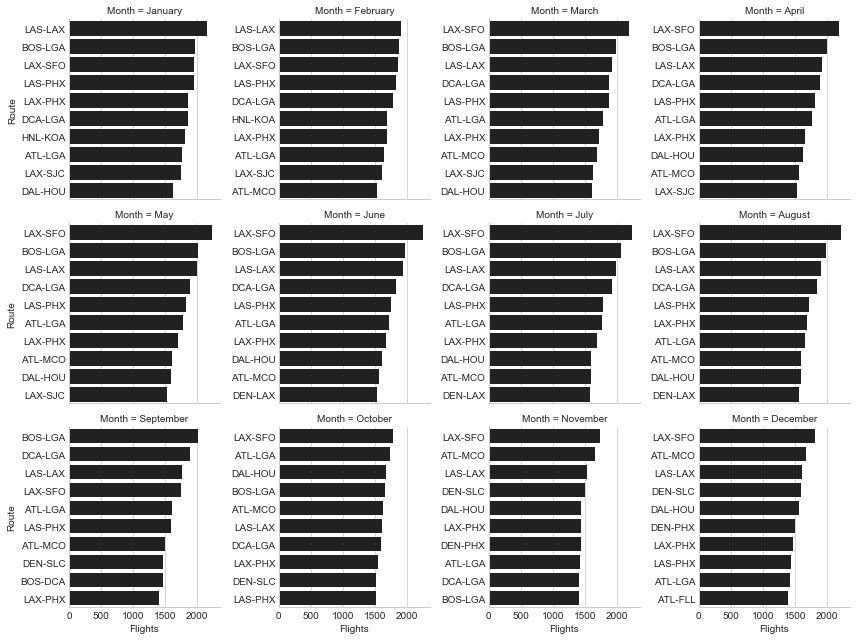

In [43]:
grid = sns.FacetGrid(routes_per_month, col="Month", col_wrap=4, col_order=month_order, sharey=False)
ax = grid.map(sns.barplot, "Flights", "Route", orient='h', color="#212121");

San Francisco - Los Angeles, Los Angeles - Las Vegas, Boston - New York, Las Vegas - Phoenix are popular routes whatever the month in the year.

Let's now see how airport trafic changes during the year:

In [44]:
dest_per_month = (routes_df
                  .groupby(["Month", "DestCity"], as_index=False)
                  .agg({"Flights": "sum"}))
dest_per_month = (dest_per_month
                  .groupby(["Month"], as_index=False)
                  .apply(lambda x: x.sort_values("Flights", ascending=False)[:10]))

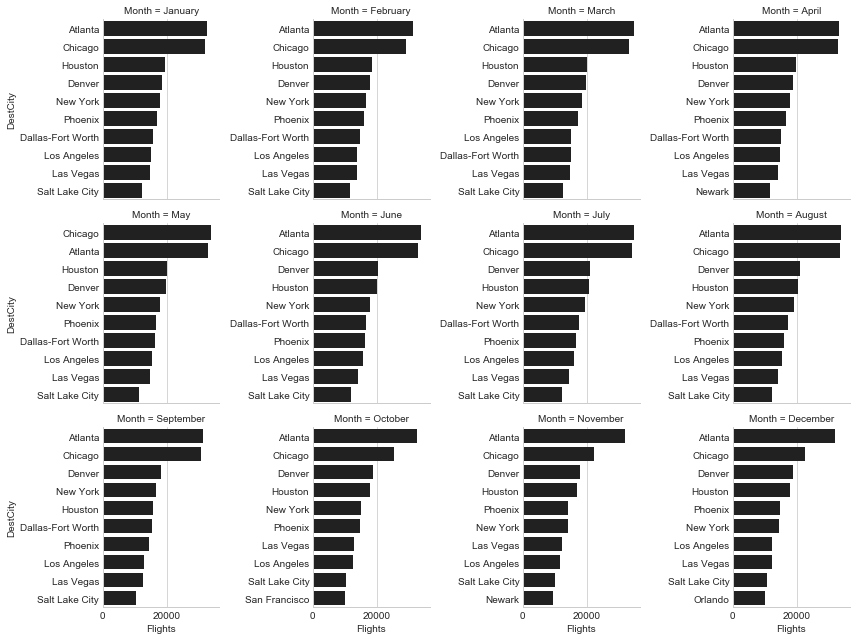

In [45]:
grid = sns.FacetGrid(dest_per_month, col="Month", col_wrap=4, col_order=month_order, sharey=False)
grid.map(sns.barplot, "Flights", "DestCity", orient='h', color="#212121");

It's funny to see that both airports with highest traffic during the year does not appear in the previous plot with most popular routes. It seems that we have big hubs connecting many destinations while on the other hand some airports have their traffic concentrated into few routes.

That's might be something we want to illustrate, the differences popular routes and most frequently used airports.

Filter out shortest routes from the overall dataset as well:

In [46]:
overall_df = (overall_df
              .merge(long_routes, on="Route", how='inner')
              .rename(columns={"Distance_x": "Distance"})
              .drop(labels="Distance_y", axis=1))

In [47]:
del routes_df
del routes_agg
del routes_per_month
del dest_per_month
del long_routes

Let's have a look at aircrafts and manufacturers.

In [48]:
aircrafts_df = (overall_df
               .groupby(["Model", "Manufacturer"], as_index=False)
               .agg({"Distance": ["count", "sum"]})
               .assign(**{"Model": lambda x: x.Model.astype(str), 
                          "Manufacturer": lambda x: x.Manufacturer.astype(str)}))
aircrafts_df.columns = aircrafts_df.columns.droplevel(1)
aircrafts_df.columns = ["Model", "Manufacturer", "Flights", "Distance"]
aircrafts_df["Fullname"] = map(lambda x: "{} ({})".format(x[0], x[1]), zip(aircrafts_df.Model, aircrafts_df.Manufacturer))
aircrafts_df.head()

,Model,Manufacturer,Flights,Distance,Fullname
0,421C,CESSNA,2650,2474427.0,421C (CESSNA)
1,550,CESSNA,1439,1155917.0,550 (CESSNA)
2,60,BEECH,1353,1050797.0,60 (BEECH)
3,65-A90,BEECH,1575,1691948.0,65-A90 (BEECH)
4,690A,AERO COMMANDER,230,536585.0,690A (AERO COMMANDER)


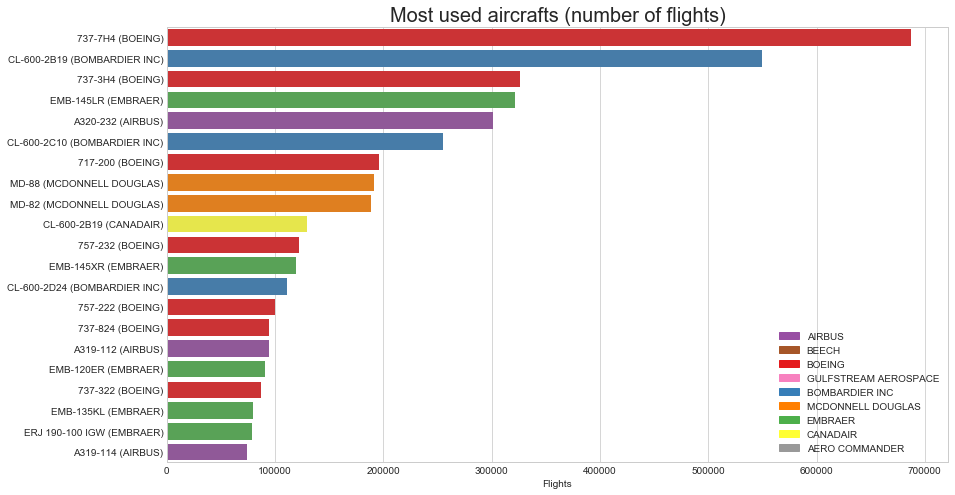

In [49]:
aircrafts_df_sorted = aircrafts_df.sort_values("Flights", ascending=False)[:21]
manuf_colors = {"BOEING": "#e41a1c", "BOMBARDIER INC": "#377eb8", "EMBRAER": "#4daf4a", 
                "AIRBUS": "#984ea3", "MCDONNELL DOUGLAS": "#ff7f00", "CANADAIR": "#ffff33",
                "BEECH": "#a65628", "GULFSTREAM AEROSPACE": "#f781bf", "AERO COMMANDER": "#999999"}
palette = map(lambda x: manuf_colors[x], aircrafts_df_sorted.Manufacturer)
ax = sns.barplot(y="Fullname", x="Flights", data=aircrafts_df_sorted, palette=palette, orient='h', ci=None)
ax.set_title("Most used aircrafts (number of flights)", fontsize=20)
ax.set_ylabel("")
handles = [ ]
for key, value in manuf_colors.iteritems():
    handles.append(mpatches.Patch(color=value, label=key))
ax.legend(handles=handles);

The BOEING 737-7H4 is by far the aircraft the most used for national flights, followed by the BOMBARDIER CL-600-2B19.

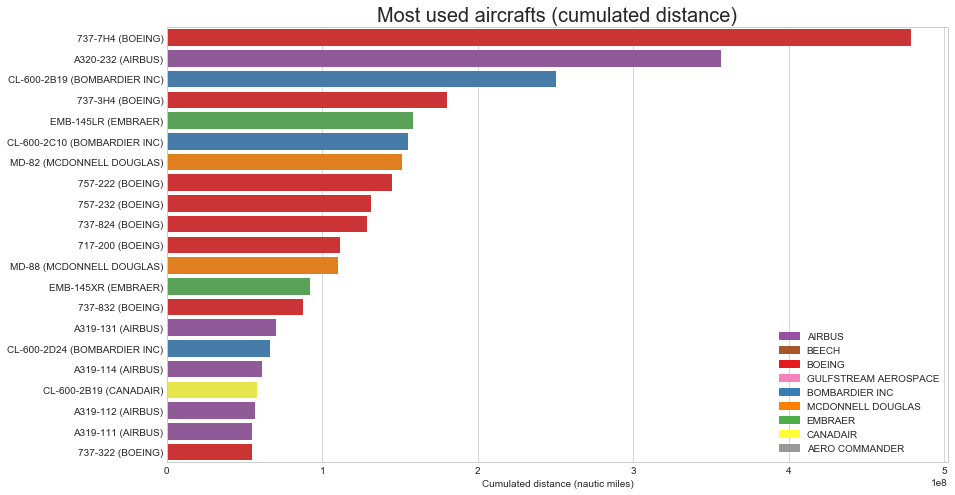

In [50]:
aircrafts_df_sorted = aircrafts_df.sort_values("Distance", ascending=False)[:21]
palette = map(lambda x: manuf_colors[x], aircrafts_df_sorted.Manufacturer)
ax = sns.barplot(y="Fullname", x="Distance", data=aircrafts_df_sorted, palette=palette, orient='h', ci=None);
ax.set_title("Most used aircrafts (cumulated distance)", fontsize=20)
ax.set_ylabel("")
ax.set_xlabel("Cumulated distance (nautic miles)")
ax.legend(handles=handles);

In cumulated distance the AIRBUS A320-232 raises to the second rank. The first place still goes to the BOEING 737-7H4.
Differences with previous plot (number of flights) may be explained by the different range of aircrafts:

In [51]:
aircrafts_df_sorted = (aircrafts_df
                      .assign(MeanRange=lambda x: x.Distance / x.Flights)
                      .sort_values("MeanRange", ascending=False)
                      .head(20))
aircrafts_df_sorted.head()

,Model,Manufacturer,Flights,Distance,Fullname,MeanRange
85,767-424ER,BOEING,2659,9919116.0,767-424ER (BOEING),3730.393381
104,A330-323,AIRBUS,1320,4031517.0,A330-323 (AIRBUS),3054.179545
83,767-3G5,BOEING,2033,5356808.0,767-3G5 (BOEING),2634.927693
81,767-33A,BOEING,4854,12754171.0,767-33A (BOEING),2627.558920
82,767-3CB,BOEING,1772,4655678.0,767-3CB (BOEING),2627.357788


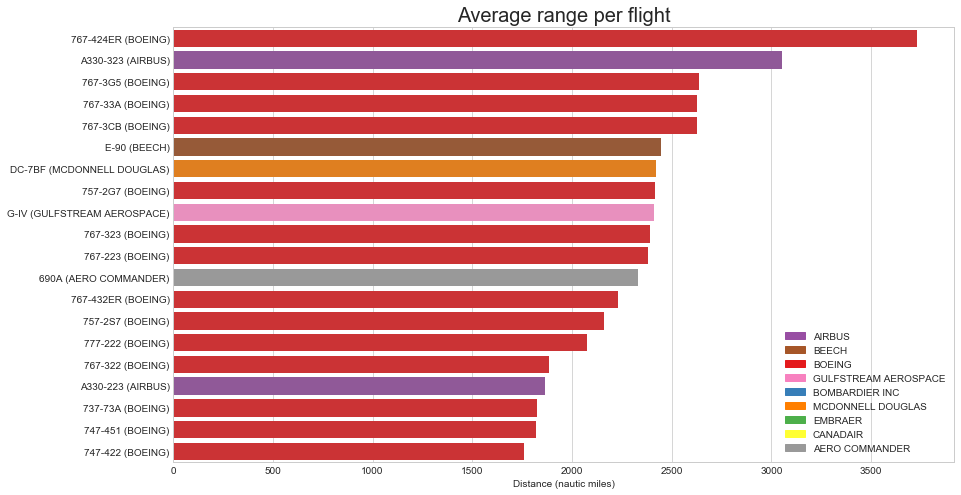

In [52]:
palette = map(lambda x: manuf_colors[x], aircrafts_df_sorted.Manufacturer)
ax = sns.barplot(y="Fullname", x="MeanRange", data=aircrafts_df_sorted, palette=palette, orient='h', ci=None);
ax.set_title("Average range per flight", fontsize=20)
ax.set_ylabel("")
ax.set_xlabel("Distance (nautic miles)")
ax.legend(handles=handles);

We mostly find BOEING aircrafts on long range distance. It might be intersting to show this result as well in final visualization: a filter of routes per aircraft manufacturer.

In [53]:
del aircrafts_df
del aircrafts_df_sorted

<a id="Delays"/>

### 5.3 Delays [*Exploratory data analysis*](#Delays)

We are interested by two main aspects:
- weather delays or cancellation depending on airport and month
- carrier delays or cancellation depending on airline, airport and aircraft 

In [54]:
delays_df = overall_df[["Month", "DayOfMonth", "Airline", "OriginAirport", "Cancelled", "CancellationCode", "CarrierDelay", 
                        "WeatherDelay", "Manufacturer", "Model", "EntryIntoService", "TailNum"]].copy()
delays_df.head()

,Month,DayOfMonth,Airline,OriginAirport,Cancelled,CancellationCode,CarrierDelay,WeatherDelay,Manufacturer,Model,EntryIntoService,TailNum
0,January,3,Southwest Airlines Co.,Washington Dulles International,False,NaN,0.0,0.0,BOEING,737-7H4,1998,N712SW
1,January,4,Southwest Airlines Co.,Tampa International,False,NaN,0.0,0.0,BOEING,737-7H4,1998,N712SW
2,October,17,Southwest Airlines Co.,Tampa International,False,NaN,0.0,0.0,BOEING,737-7H4,1998,N712SW
3,January,3,Southwest Airlines Co.,Washington Dulles International,False,NaN,0.0,0.0,BOEING,737-7H4,2000,N772SW
4,November,21,Southwest Airlines Co.,Tampa International,False,NaN,0.0,0.0,BOEING,737-7H4,2000,N772SW


We need to define a criterion for weather conditions:
- either the flight is cancelled for weather conditions
- or the flight is delayed by more than 15 minutes due to weather conditions

In [55]:
cond = (delays_df.Cancelled & (delays_df.CancellationCode == "Weather")) | (delays_df.WeatherDelay >= 15)
delays_df["Weather"] = 1.
delays_df.Weather.where(cond, 0., inplace=True)

Let's have a look at occurences of cancellations or delays all along the year:

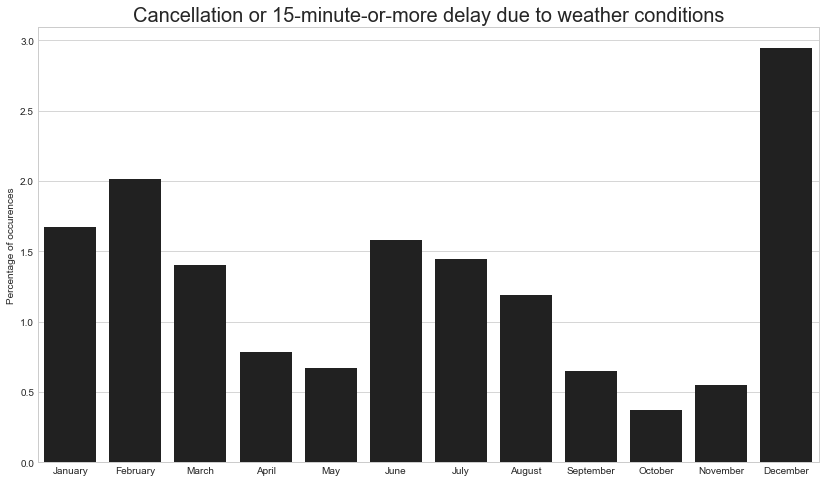

In [56]:
weather_df = (delays_df
                 .groupby("Month", as_index=False)
                 .agg({"Weather": lambda x: 100.* x.sum() / x.count()}))
ax = sns.barplot(y="Weather", x="Month", data=weather_df, ci=None, order=month_order, color="#212121")
ax.set(xlabel="", ylabel="Percentage of occurences")
ax.set_title("Cancellation or 15-minute-or-more delay due to weather conditions", fontsize=20);
del weather_df

We can do something similar with airports:

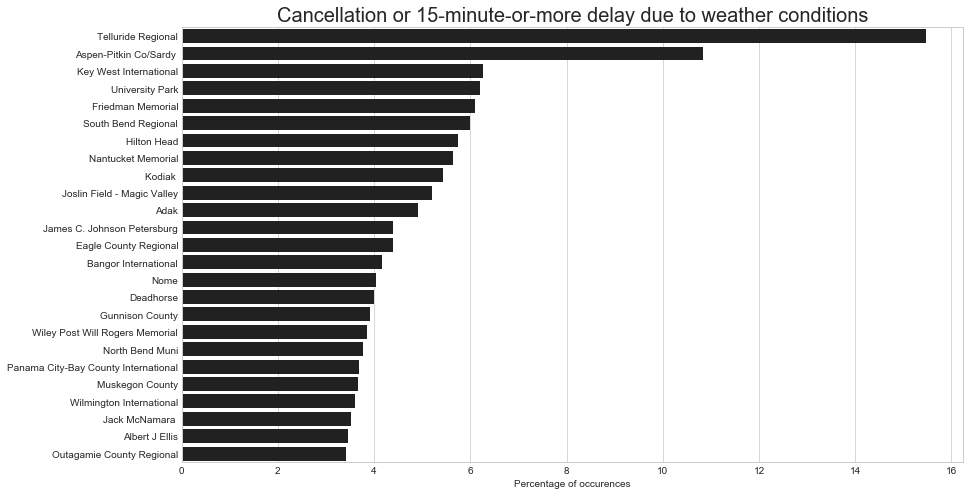

In [57]:
weather_df = (delays_df
              .groupby("OriginAirport", as_index=False)
              .agg({"Weather": lambda x: 100.* x.sum() / x.count()})
              .sort_values("Weather", ascending=False)
              .head(25))
ax = sns.barplot(x="Weather", y="OriginAirport", data=weather_df, ci=None, color="#212121")
ax.set(ylabel="", xlabel="Percentage of occurences")
ax.set_title("Cancellation or 15-minute-or-more delay due to weather conditions", fontsize=20);
del weather_df

We will use the same methodology for carrier delay, this time the criterion is:
- either the flight is cancelled for carrier reasons
- or the flight is delayed by more than 15 minutes due to carrier

In [58]:
cond = (delays_df.Cancelled & (delays_df.CancellationCode == "Carrier")) | (delays_df.CarrierDelay >= 15)
delays_df["Carrier"] = 1.
delays_df.Carrier.where(cond, 0., inplace=True)

Let's have a look at occurences of cancellations or delays caused by carrier as a function of aircraft manufacturer:

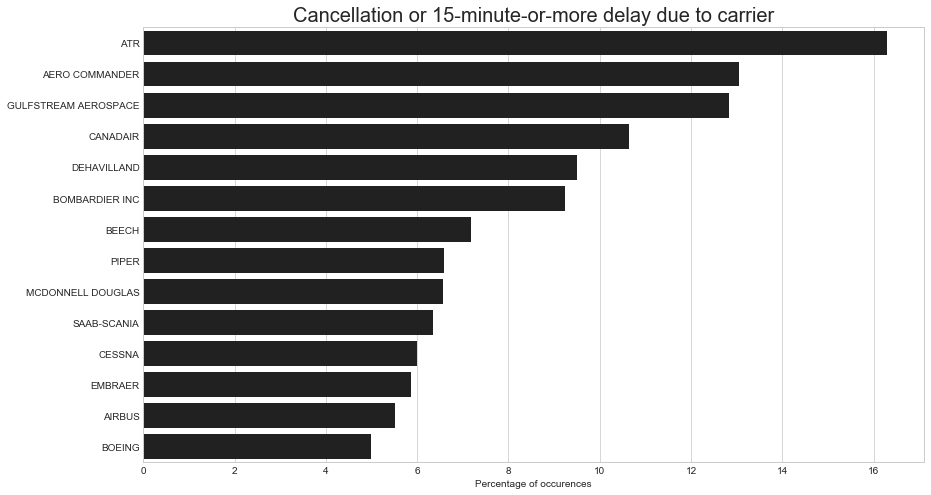

In [59]:
carrier_df = (delays_df
              .groupby("Manufacturer", as_index=False)
              .agg({"Carrier": lambda x: 100.* x.sum() / x.count()})
              .assign(Manufacturer=lambda x:x.Manufacturer.astype(str))
              .sort_values("Carrier", ascending=False))
ax = sns.barplot(y="Manufacturer", x="Carrier", data=carrier_df, ci=None, color="#212121")
ax.set(ylabel="", xlabel="Percentage of occurences")
ax.set_title("Cancellation or 15-minute-or-more delay due to carrier", fontsize=20);
del carrier_df

And low let's do this as a function of airline:

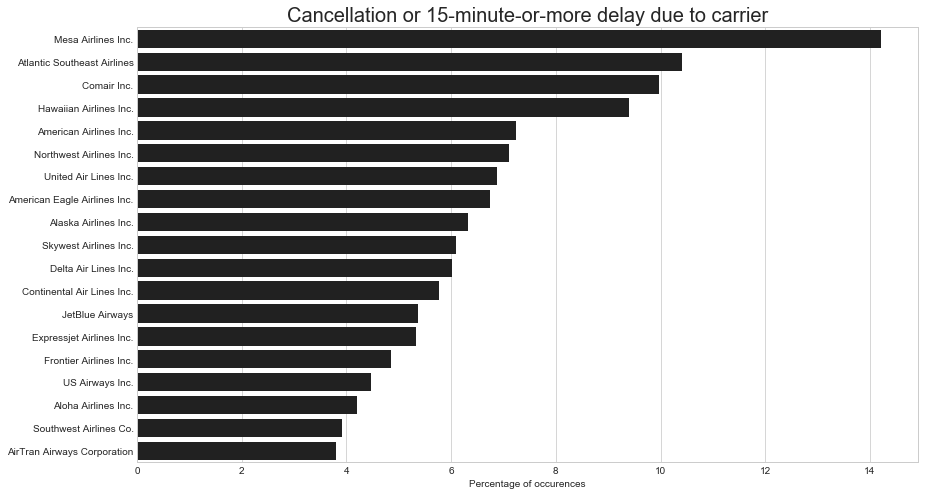

In [60]:
carrier_df = (delays_df
              .groupby("Airline", as_index=False)
              .agg({"Carrier": lambda x: 100.* x.sum() / x.count()})
              .assign(Airline=lambda x:x.Airline.astype(str))
              .sort_values("Carrier", ascending=False))
ax = sns.barplot(y="Airline", x="Carrier", data=carrier_df, ci=None, color="#212121")
ax.set(ylabel="", xlabel="Percentage of occurences")
ax.set_title("Cancellation or 15-minute-or-more delay due to carrier", fontsize=20);
del carrier_df

This is an interesting result. There may be a huge difference between airlines in terms of cancellation or delay rate due to their own responsibility. This is something we want to show in the final visualization.

Finally, let's find out if there is any airport where carrier delays are more frequent:

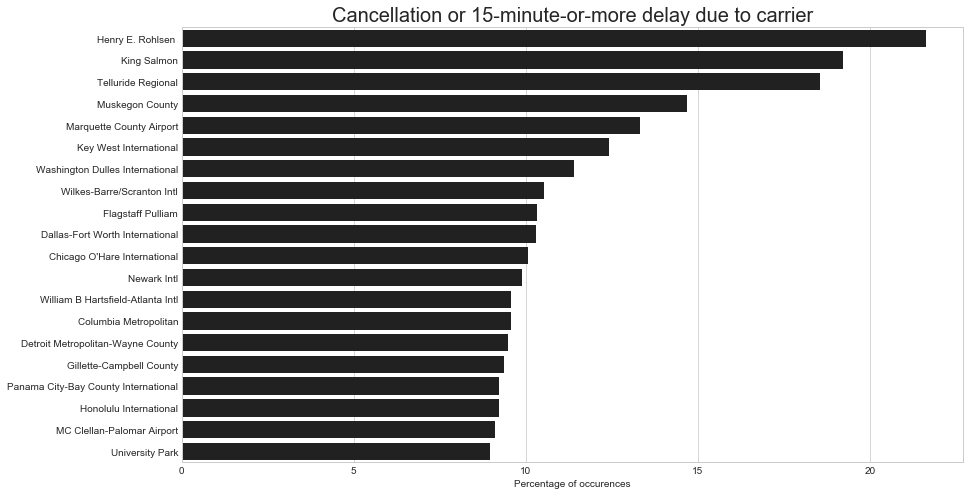

In [61]:
carrier_df = (delays_df
              .groupby("OriginAirport", as_index=False)
              .agg({"Carrier": lambda x: 100.* x.sum() / x.count()})
              .assign(OriginAirport=lambda x:x.OriginAirport.astype(str))
              .sort_values("Carrier", ascending=False)
              .head(20))
ax = sns.barplot(y="OriginAirport", x="Carrier", data=carrier_df, ci=None, color="#212121")
ax.set(ylabel="", xlabel="Percentage of occurences")
ax.set_title("Cancellation or 15-minute-or-more delay due to carrier", fontsize=20);
del carrier_df

The airport in American Virgin Islands (Henry E. Rohlsen) has a cancellation / delay rate of almost 30% !!

Is there anything related to the age of aircraft ?

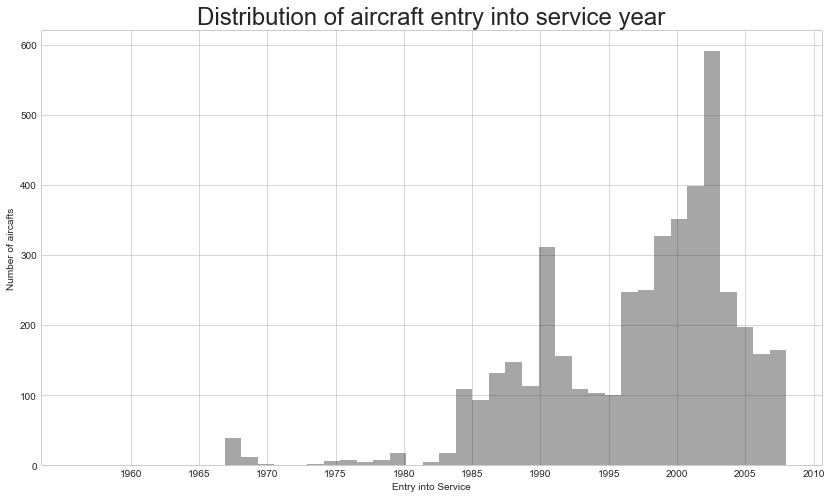

In [62]:
aircrafts_df = (delays_df
                .groupby(["TailNum", "Manufacturer"], as_index=False)
                .agg({"EntryIntoService": "first"})
                .assign(Manufacturer=lambda x:x.Manufacturer.astype(str))
                .query("Manufacturer not in ('AERO COMMANDER',)"))
ax = sns.distplot(aircrafts_df["EntryIntoService"], norm_hist=False, kde=False, color="#212121")
ax.set_xticks(np.arange(1960, 2015, 5))
ax.set_ylabel("Number of aircafts")
ax.set_xlabel("Entry into Service")
ax.set_title("Distribution of aircraft entry into service year", fontsize=24);

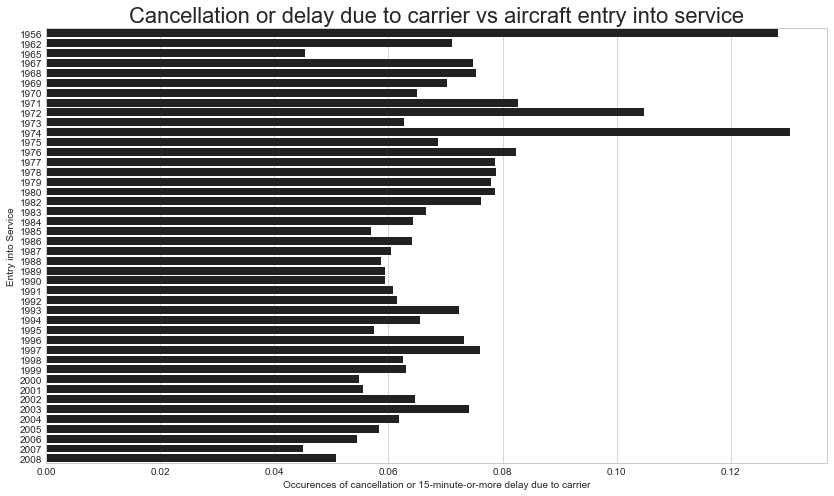

In [63]:
aircrafts_df = (delays_df
                .groupby(["EntryIntoService"], as_index=False)
                .agg({"Carrier": lambda x: x.sum() / x.count()}))
ax = sns.barplot(y="EntryIntoService", x="Carrier", data=aircrafts_df, orient='h', color="#212121");
ax.set(xlabel="Occurences of cancellation or 15-minute-or-more delay due to carrier", ylabel="Entry into Service")
ax.set_title("Cancellation or delay due to carrier vs aircraft entry into service", fontsize=22);

There is nothing clear and obvious. In more recent aircrafts (from 2003), it seems that we have a decrease in occurences of cancellation and delays. But this is also a pattern we find between 1997 and 2001.

In [64]:
del aircrafts_df
del delays_df

<a id="Preparation">

## 6. Data Preparation for Visualization [*Top*](#Top)

In this section, we will prepare the dataset for final visualization. We need to define what we want to visualize on the US map:

- airports location with associated traffic as a circle on the map
- routes from origin airport to destination airport with thickness representative of the number of flights on that route

In terms of animation we want to see the various routes, stats of aircrafts used as function of route length. This will enable to limit the overplot on the map.

This is to show that various aircrafts are used depending on routes and that we have different types of airports:

- with a lot of traffic but to many destinations
- with less traffic but highly used routes.

We need to keep the following parameters in the final dataset:

- Route
- Airline
- Manufacturer
- OriginLat
- OriginLong
- OriginAirport
- OriginCity
- OriginState
- DestLat
- DestLong
- DestAirport
- DestCity
- DestState
- Distance

The idea is to keep only a single entry per route, airline and manufacturer. An additional parameter will be created with total number of flights for each entry.

The routes from or to Alaska, Puerto Rico and Hawaii are filtered out to keep data centered on metropolitan area. We also exclude flights from or to Virgin Islands.

In [65]:
final_df = overall_df[["Route", "Airline", "Manufacturer", 
                       "OriginLat", "OriginLong", "OriginAirport", "OriginCity", "OriginState",
                       "DestLat", "DestLong", "DestAirport", "DestCity", "DestState", 
                       "Distance"]]
final_df = (final_df
            .assign(Flights=lambda x: x.Distance)
            .groupby(["Route", "Airline", "Manufacturer"], as_index=False)
            .aggregate({"OriginLat": "first", 
                        "OriginLong": "first", 
                        "OriginAirport": "first", 
                        "OriginCity": "first",
                        "OriginState": "first",
                        "DestLat": "first",
                        "DestLong": "first",
                        "DestAirport": "first",
                        "DestCity": "first",
                        "DestState": "first",
                        "Distance": "first",
                        "Flights": "count"})
            .sort_values("Distance", ascending=True)
            .assign(OriginAirport=lambda x:x.OriginAirport.str.strip(), DestAirport=lambda x:x.DestAirport.str.strip()))

In [66]:
final_df = final_df[(final_df.OriginState != "AK") & 
         (final_df.DestState != "AK") & 
         (final_df.OriginState != "PR") & 
         (final_df.DestState != "PR") &
         (final_df.OriginState != "HI") & 
         (final_df.DestState != "HI") &
         (final_df.OriginState != "VI") & 
         (final_df.DestState != "VI")]

In [67]:
final_df.head()

,Route,Airline,Manufacturer,Distance,DestState,DestLong,DestAirport,DestLat,OriginLong,OriginAirport,OriginState,OriginLat,Flights,DestCity,OriginCity
4047,FAT-SBP,Skywest Airlines Inc.,CANADAIR,118,CA,-119.718140,Fresno Yosemite International,36.776196,-120.642395,San Luis Obispo Co-McChesney,CA,35.237057,1,Fresno,San Luis Obispo
1929,BZN-GTF,Skywest Airlines Inc.,BOMBARDIER INC,118,MT,-111.153008,Gallatin,45.776901,-111.370682,Great Falls Intl,MT,47.482002,1,Bozeman,Great Falls
2188,CLT-FAY,Mesa Airlines Inc.,BOMBARDIER INC,118,NC,-78.879997,Fayetteville Municipal,34.991470,-80.943123,Charlotte/Douglas International,NC,35.214012,184,Fayetteville,Charlotte
4064,FLG-PHX,Mesa Airlines Inc.,CANADAIR,119,AZ,-112.008057,Phoenix Sky Harbor International,33.434166,-111.671219,Flagstaff Pulliam,AZ,35.138454,34,Phoenix,Flagstaff
4038,FAT-MRY,Expressjet Airlines Inc.,EMBRAER,119,CA,-121.842949,Monterey Peninsula,36.586983,-119.718140,Fresno Yosemite International,CA,36.776196,2,Monterey,Fresno


In [68]:
final_df.to_csv("routes.csv", index=False)

<a id="Appendix">

## 7. Appendix [*Top*](#Top)

In [70]:
#Convert notebook to html
!jupyter nbconvert --to html --template html_minimal.tpl effective_visualization.ipynb

[NbConvertApp] Converting notebook effective_visualization.ipynb to html
[NbConvertApp] Writing 1319122 bytes to effective_visualization.html


List of airports on [Wikipedia](https://en.wikipedia.org/wiki/List_of_airports).<hr>

List of airlines on [Wikipedia](https://en.wikipedia.org/wiki/Airline_codes).<hr>

Aviation references http://www.planemapper.com/aircrafts, http://www.aviationdb.com/Aviation/AircraftQuery.shtm, http://www.airfleets.net.<hr>

GeoJSON sites: https://geojson-maps.ash.ms/, https://bubinga.co/geojson-us-states-and-counties/, http://wiki.geojson.org/GeoJSON_draft_version_6#LineString, https://stackoverflow.com/a/39988387/8500344.<hr>

Bootstrap documentation and themes used: https://bootswatch.com/darkly/, https://getbootstrap.com/.<hr>

D3.js resource for tooltips: http://bl.ocks.org/d3noob/a22c42db65eb00d4e369.<hr>







